In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.integrate import solve_ivp
import scipy.stats as st
from scipy.stats import norm 
from scipy.stats import nct
from scipy.integrate import odeint
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Define the parameters
r1 = 0.038
r2 = 0.042
Kp1 = 1.5
Kp2 = 9.7
#m12 = 0.0
#m21 = 0.01
alpha1 = 0.5
a1 = 2.7
a2 = 1.7
s1 = 0.25
s2 = 0.21
δ1 = 0.05
δ2 = 0.05
Cm = 0.7
σ1 = 0.03
σ2 = 0.03
re1 = 0.1
re2 = 0.1
u = 0.0025
α = 0.1
eb = 0.00004
η = 1
Tg = 50
G1 = 5.0
G0 = 20
#ypc access, affinity distribution, aspiration? 
asp1 = 10
asp2 = 4
pos1 = 15
pos2 = 2 

#remittances
r12 = 0
r21 = 0.1

# Time step and total time
dt = 1
t_total = 1000.0
steps = int(t_total / dt)

#define functions
def teta(x):
    y = np.maximum(0,x)**5/(0.0001**5 + np.maximum(0,x)**5)
    return y

def phi(x): 
    y = teta(x)*x
    return y

def Yi(a,alpha,K,P):
    y = a*(phi(K)**alpha)*P**(1-alpha)
    return y 

def Y(P,Y): 
    y = P + phi(Y-P) 
    return y 

def er(eb,e,p,Yi): ##decarbonization function 
    y = teta(p-Yi)*eb + teta(Yi-p)*e
    return y

def ypc(Y,P):
    y = Y/P
    return y

def pop(P1,P2):
    y = P1/(P1+P2)
    return y 

def mij(ypci,ypcj,asp,pop,pos):
    y = (1/(1+ (ypci/(ypci+ypcj))))**asp #- (1/(1+pop))**pos ## pos =possibilities
    return y

def Mij(P,m):
    y = P*m 
    return y

def rem(D,Y,P,r):#share r of diaspora D in destination sends per capita income Y/P back 
    y = D*(Y/P)*r
    return y 

def trans(x):
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return x


In [3]:
n = 50
df_P1 = pd.DataFrame(np.zeros((steps,n)))
df_P2 = pd.DataFrame(np.zeros((steps,n)))
df_K1 = pd.DataFrame(np.zeros((steps,n)))
df_K2 = pd.DataFrame(np.zeros((steps,n)))
df_G = pd.DataFrame(np.zeros((steps,n)))
df_z = pd.DataFrame(np.zeros((steps,n)))
df_e1 = pd.DataFrame(np.zeros((steps,n)))
df_e2 = pd.DataFrame(np.zeros((steps,n)))
df_Y1 = pd.DataFrame(np.zeros((steps,n)))
df_Y2 = pd.DataFrame(np.zeros((steps,n)))


In [130]:
for i in range(0,n):

## remittances 
# Initial conditions
    P1 = 0.24
    P2 = 0.24
    K1 = 0
    K2 = 0
    G = 2.8
    z = 0.0
    e1 = 0.0004
    e2 = 0.0004

# Simulation loop
    for step in range(steps):

    #parameter from functions
     Yi1 = Yi(a1,alpha1,K1,P1)
     Yi2 = Yi(a2,alpha1,K2,P2)

     Y1 = Y(P1,Yi1)
     Y2 = Y(P2,Yi2)

     Yd1 = phi(Y1-P1*Cm)#-r21*M21*ypc1)
     Yd2 = phi(Y2-P2*Cm)#+r21*M21*ypc1)

     er1 = er(eb,e1,P1,Yi1)#teta(P1-Yi1)*eb + teta(Yᵢ₁-P₁)*e1
     er2 = er(eb,e2,P2,Yi2)#teta(P2-Yi2)*eb + teta(Yᵢ₂-P₂)*e₂

     ypc1 = ypc(Y1,P1)
     ypc2 = ypc(Y2,P2)

### non central student distribution (see Zantout and Schewe 2023)

# Parameters for P4 (first P4 because of population size but with increasing G maybe P1)
     mu = -6.98e-5
     sigma = 1.89e-5
     degf = 1.11
     nc = 24.82
     dist_1 = st.nct.rvs(degf, nc, loc=mu, scale=sigma)

    ## for P1
    # Parameters for P1
     mu_p1 = -4.53e-3
     sigma_p1 = 3.66e-4
     degf_p1 = 2.17
     nc_p1 = 24.19

     dist_2 = st.nct.rvs(degf_p1, nc_p1, loc=mu_p1, scale=sigma_p1)

    ## stronger migration 
    # Parameters for P1
     mu_3 = -1.0e-3
     sigma_3 = 2.0e-4
     degf_3 = 3.07
     nc_3 = 24.00

     dist_3 = st.nct.rvs(degf_3, nc_3, loc=mu_3, scale=sigma_3)



     m21 = trans(dist_2)
     m12 = 0#np.random.normal(0,0.1)
     #r21 = np.random.normal()
     r21 = 0.05

     R12 = rem(D21,Y2,P2,r12) # moneay equivalent 
     R21= rem(D12,Y1,P1,r21) 

     M12 = Mij(P1,m12)
     M21 = Mij(P2,m21)

    # Save current state
     df_P1.loc[step, i] = P1
     df_P2.loc[step, i] = P2
     df_K1.loc[step, i] = K1
     df_K2.loc[step, i] = K2
     df_G.loc[step, i] = G
     df_z.loc[step, i] = z
     df_e1.loc[step, i] = e1
     df_e2.loc[step, i] = e2
     df_Y1.loc[step, i] = Y1
     df_Y2.loc[step, i] = Y2
    
    # Calculate derivatives
     dP1 = r1*P1*(1 - (P1/Kp1)) + M21
     dP2 = r2 * P2 * (1 - (P2/Kp2)) - M21
     dK1 = s1*Yd1 - δ1*K1 - σ1*np.exp(G - G1)*K1 
     dK2 = s2 * Yd2- δ2 * K2 - σ2*np.exp(G - G1)*K2 
     dG = er1*Y1 + er2 * Y2 - u * (G-2.8) + α*teta(G-G0)
     dz = η * teta(G - Tg) * (1 - z)
     de1 = -z * re1 * e1
     de2 = -z * re2 * e2

    # Update state variables
     P1 += dP1 * dt
     P2 += dP2 * dt
     K1 += dK1 * dt
     K2 += dK2 * dt
     G += dG * dt
     z += dz * dt
     e1 += de1 * dt
     e2 += de2 * dt
   

In [120]:
st.nct.rvs(degf_p1, nc_p1, loc=mu_p1, scale=sigma_p1)*10

0.06233386944739531

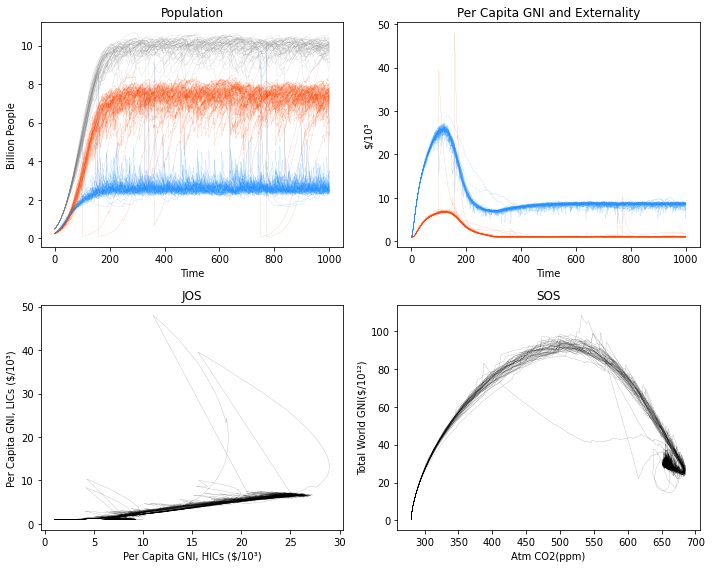

In [131]:
x1 = np.linspace(0,steps,steps)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i in range(1,n):
    # Create a figure and a 2x2 grid of subplots
# First subplot
    axs[0, 0].plot(x1, df_P1[i], 'dodgerblue',linewidth=0.1)
    axs[0, 0].plot(x1, df_P2[i], 'orangered',linewidth=0.1)
    axs[0, 0].plot(x1, df_P2[i]+df_P1[i], 'grey',linewidth=0.1)
    axs[0, 0].set_title('Population')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Billion People')

# Second subplot
    axs[0, 1].plot(x1, df_Y1[i]/df_P1[i], 'dodgerblue',linewidth=0.1)
    axs[0, 1].plot(x1, df_Y2[i]/df_P2[i], 'orangered',linewidth=0.1)
    axs[0, 1].set_title('Per Capita GNI and Externality')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('$/10³')

# Third subplot
    axs[1, 0].plot(df_Y1[i]/df_P1[i], df_Y2[i]/df_P2[i], 'black',linewidth=0.1)
    axs[1, 0].set_title('JOS')
    axs[1, 0].set_xlabel('Per Capita GNI, HICs (\$/10³)')
    axs[1, 0].set_ylabel('Per Capita GNI, LICs (\$/10³)')

# Fourth subplot
    axs[1, 1].plot(df_G[i]*100,df_Y2[i]+df_Y1[i],'black',linewidth=0.1)
    axs[1, 1].set_title('SOS')
    axs[1, 1].set_xlabel('Atm CO2(ppm)')
    axs[1, 1].set_ylabel('Total World GNI(\$/10¹²)')


# Adjust layout to prevent overlap
plt.tight_layout()
